# Constraint Handling

Constraint handling is often neglected in frameworks but is indeed a very important aspect of optimization.
Depending on the characteristics of the constraints one method might be more suitable and lead to better results than another.
In principle, two ways exist how constraints can be dealt with: a) use an algorithm which is able to handle constraints internally; b) redefine the problem to have no constraints but still guarantee the optimum to be a feasible solutions. 
Both strategies will be elaborated in the following.

By default the returned optimum is **always** required to be feasible. In some situations it might be required to obtain the **least infeasible** solution if no feasible could have been found. To enable this behavior you can pass `return_least_infeasible=True` to the `minimize` function. 

In [1]:
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_problem
from pymoo.optimize import minimize

res = minimize(get_problem("g05"),
               GA(),
               return_least_infeasible=True,
               seed=1,
               verbose=False)

print("CV:", res.CV[0])
print("F:", res.F[0])

CV: 0.01707583254530075
F: 5186.280990822757


## Inequality Constraints

In my inequality constraints are always defined as "$\leq 0$" constraints. Thus, constraint violation is defined as follows: A solution is considered as **feasible** of all constraint violations are **less than** zero. A solution is considered as **infeasible** if at least one constraint violation is **larger than** zero. 


For instance, the constraint 

$$
- x^4 \geq - 2
$$

Has to be converted to a "$\leq 0$" constraints to satisfy the implementation of constraints in pymoo:

$$
x^4  \leq 2\\
x^4 - 2 \leq 0
$$

Let us assume the whole optimization problem is then given by:

\begin{align} 
\begin{split}
\min \;\; & f(x) = 1 + x^3 \\ 
\text{s.t.} \;\; & x^4 - 2\leq 0\\
& -2 \leq x \leq 2
\end{split}
\end{align}

The figure below shows the corresponding function and the optimum to be found. The constraint function is shown with a dashed line where greater than zero (violated) and with a solid line where less or equal to zero (satisfied). The optimum is shown by a red cross which is minimum in the feasible region.

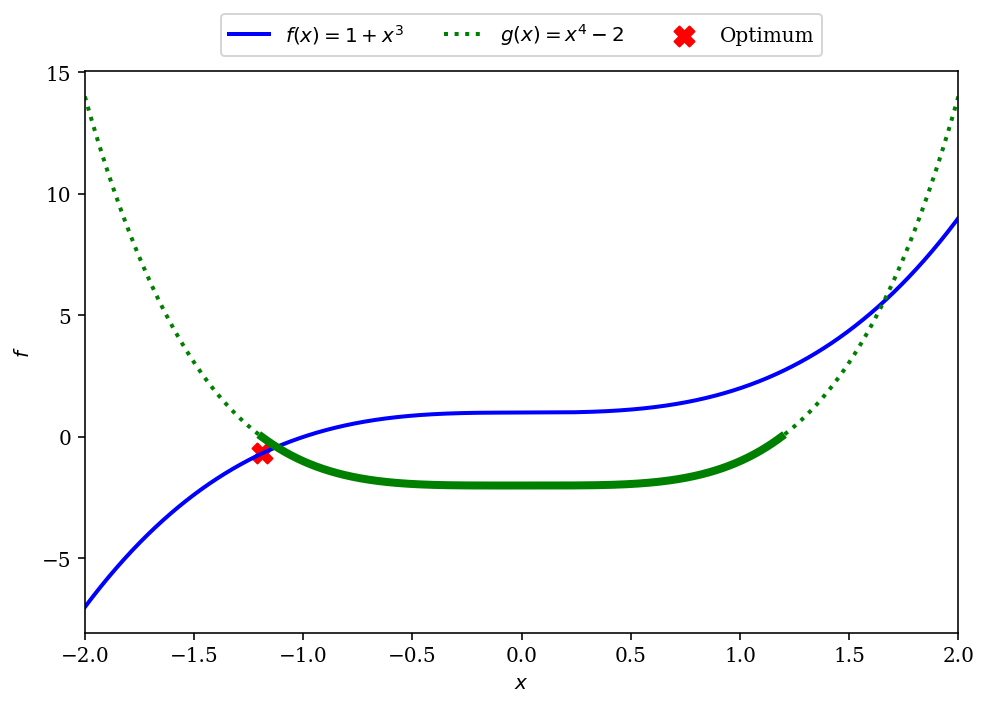

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')

X = np.linspace(-2, 2, 10000)

F = 1 + X ** 3
G = X**4 - 2


plt.figure(figsize=(7, 5))

plt.plot(X, F, linewidth=2.0, color="blue", label="$f(x) = 1 + x^3$")

I = G<=0
plt.plot(X[I], G[I], linewidth=4.0, color="green")
plt.plot(X, G, linewidth=2.0, color="green", label="$g(x) = x^4 - 2$", linestyle='dotted')



plt.scatter([-1.18920654], [-0.6817904], color="red", s=100, marker="X", label="Optimum")
plt.xlim(-2, 2)
plt.xlabel("$x$")
plt.ylabel("$f$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

The problem can be implemented straightforwardly:

In [3]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=1,
                         n_obj=1,
                         n_constr=1,
                         xl=-2,
                         xu=2)

    def _evaluate(self, X, out, *args, **kwargs):
        out["F"] = 1 + X ** 3
        out["G"] = X**4 - 2

And then being solved as usually by initiating the problem, algorithm and running the minimize method:

In [4]:
from pymoo.algorithms.so_pso import PSO
from pymoo.optimize import minimize

problem = MyProblem()

algorithm = PSO()

res = minimize(problem,
               algorithm,
               seed=1,
               verbose=False)

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Best solution found: 
X = [-1.18920654]
F = [-0.6817904]
CV = [0.]


For a bi-objective example with constraints, we like to refer to our [Getting Started Guide](../getting_started.ipynb) where a similar example is shown.

## Equality to Inequality Constraints

We got a couple of questions of how equality constraints should be handled in a genetic algorithm. In general, functions without any smoothness are challenging to handle for genetic algorithms. An equality constraint is basically an extreme case, where the constraint violation is 0 at exactly one point and otherwise 1. 

Let us consider the following constraint $g(x)$ where $x$ represents a variable:

$g(x): x = 5$

An equality constraint can be expressed by an inequality constraint:

$g(x): |x - 5| \leq 0$   

or

$g(x): (x-5)^2   \leq 0$

However, all of constraints above are very strict and make **most of the search space infeasible**. Without providing more information to the algorithm those constraint are very difficult to satisfy.

For this reason, the constraint can be smoothed by adding an epsilon to it and, therefore, having two inequality constraints:

$g'(x): 5 - \epsilon \leq x \leq 5 + \epsilon$

Also, it can be simply expressed in one inequality constraint by:

$g'(x): (x-5)^2  - \hat{\epsilon} \leq 0$

Depending on the $\epsilon$ the solutions will be more or less close to the desired value. However, the genetic algorithm does not know anything about the problem itself which makes it difficult to handle and focus the search in the infeasible space.

## Parameter-less Approach / Feasibility First

This is the default constraint handling approach in **pymoo**. It strictly prefers feasible over infeasible solutions. 

$$
F(x)=
\begin{cases}
f(x), \quad \text{if feasible} \\
f_{\max} + \sum_{j=1}^{|J|} \, \langle \, g_j (x) \, \rangle, \quad \rm{otherwise}
\end{cases}
$$

where $\langle \cdot \rangle$ is defined by 

$$
\langle a \rangle = 
\begin{cases}
a, \quad a \geq 0 \\
0, \quad \rm{otherwise}
\end{cases}
$$

This approach works well if an algorithm is based on comparisons. For instance, a genetic algorithm has to determine what individuals survive. Thus, this mapping can be utilized to create a rank for each individual. 
If the $f_\max$ of the function is known beforehand this can also be used for redefining the problem beforehand. 
Redefining the problem is very similar to the approach discussed next.

## Penalty-based Approach / Lagrange Multipliers

For this approach internally equality constraints are converted to inequality constraints. Then, the violation of inequality and equality constraints penalize the objective value. This makes all non-constrained algorithms applicable, however, also might create a more difficult fitness landscape to solve. 

### Single-objective

\begin{align} 
\begin{split}
\min \;\; & f(x) = x_1^2 + x_2^2 + x_3^2 \\ 
\text{s.t.} \;\; & x_1 \cdot x_2 \geq 1\\
& x_1 \cdot x_2 \leq 5\\
& x_2 + x_3 = 1\\
& 0 \leq x \leq 5
\end{split}
\end{align}

By converting the constraints to $\leq 0$ constraints the implementation of the problem looks as follows:

In [5]:
def func_obj(x):
    return x[0] ** 2 + x[1] ** 2 + x[2] ** 2

constr_ieq = [
    lambda x: 1 - x[0] * x[1],
    lambda x: x[0] * x[1] - 5
]

constr_eq = [
    lambda x: 1 - x[1] - x[2]
]

For this example, we use the definition of a problem using the factory method `create_problem_from_funcs`:

In [6]:
from pymoo.model.problem import FunctionalProblem
from pymoo.model.problem import ConstraintsAsPenaltyProblem

problem = FunctionalProblem(3,
                            func_obj,
                            xl=0,
                            xu=5,
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq
                            )

problem = ConstraintsAsPenaltyProblem(problem, penalty=1e6)

Then, an algorithm can be used to solve the problem as usual:

In [7]:
from pymoo.algorithms.so_pso import PSO
from pymoo.optimize import minimize


algorithm = PSO(pop_size=50)

res = minimize(problem, algorithm, seed=1)

opt = res.opt[0]
X, F, CV = opt.get("X", "__F__", "__CV__")

print("Best solution found: \nX = %s\nF = %s\nCV = %s\n" % (X, F, CV))

Best solution found: 
X = [1.25468499 0.79701394 0.20298647]
F = [2.25066914]
CV = [0.]



### Multi-objective

The almost equivalent could be applied for multi-objective optimization problems. The example below shows the [getting started guide](../getting_started.ipynb) example with a penalty being used to deal with the constraints:

#### Functions

In [8]:
objs = [
    lambda x: x[0]**2 + x[1]**2,
    lambda x: (x[0]-1)**2 + x[1]**2
    
]

constr_ieq = [
    lambda x: 2*(x[0]-0.1) * (x[0]-0.9) / 0.18,
    lambda x: - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8
]

constr_eq = []

#### Problem

In [9]:
from pymoo.model.problem import FunctionalProblem
from pymoo.model.problem import ConstraintsAsPenaltyProblem

problem = FunctionalProblem(2,
                            objs,
                            xl=-2,
                            xu=2,
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq
                            )

problem = ConstraintsAsPenaltyProblem(problem, penalty=1e6)

#### Optimize

In [10]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=40)

res = minimize(problem,
               algorithm,
               seed=1)

#### Visualize

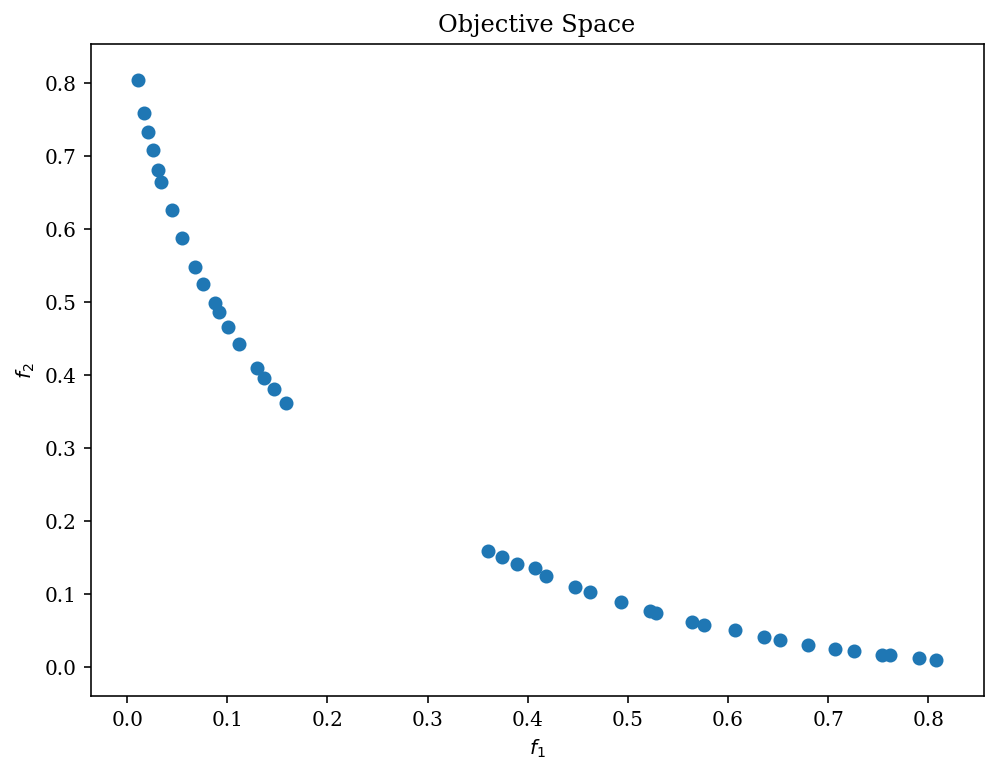

In [11]:
from pymoo.visualization.scatter import Scatter

plot = Scatter(title = "Objective Space")
plot.add(res.F)
plot.show()

## Repair Operator 

A simple approach is to handle constraints through a repair function. This is only possible if the equation of the constraint is known. The repair makes sure every solution that is evaluated is in fact feasible. Let us consider the following example where 
the equality constraints need to consider more than one variable:

\begin{align} 
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\max \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\[1mm]
\text{s.t.} \;\; & g_1(x_1, x_3) : x_1 + x_3 = 2\\[2mm]
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2 \\
& -2 \leq x_3 \leq 2
\end{split}
\end{align}

We implement the problem using by squaring the term and using an $\epsilon$ as we have explained above. The source code for the problem looks as follows:

In [12]:
import numpy as np

from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array([-2, -2, -2]),
                         xu=np.array([2, 2, 2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0] ** 2 + x[:, 1] ** 2
        f2 = (x[:, 0] - 1) ** 2 + x[:, 1] ** 2
        g1 = (x[:, 0] + x[:, 2] - 2) ** 2 - 1e-5

        out["F"] = np.column_stack([f1, f2])
        out["G"] = g1


As you might have noticed the problem has similar characteristics to problem in our getting started. 
Before a solution is evaluated a repair function is called. To make sure a solution is feasible, an approach would be to either set $x_3 = 2 - x_1$ or $x_1 = 2 - x_3$. Additionally, we need to consider that this repair might produce a variable to be out of bounds.

In [13]:
from pymoo.model.repair import Repair

class MyRepair(Repair):

    def _do(self, problem, pop, **kwargs):
        for k in range(len(pop)):
            x = pop[k].X
            if np.random.random() < 0.5:
                
                x[2] = 2 - x[0]
                if x[2] > 2:
                    val = x[2] - 2
                    x[0] += val
                    x[2] -= val
                    
            else:
                x[0] = 2 - x[2]
                if x[0] > 2:
                    val = x[0] - 2
                    x[2] += val
                    x[0] -= val
                
                
        return pop

Now the algorithm object needs to be initialized with the repair operator and then can be run to solve the problem:

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |  0.00000E+00 |  0.00000E+00 |       5 |            - |            - |            -
    2 |     200 |  0.00000E+00 |  0.00000E+00 |      11 |  0.055618092 |  0.382047403 |  0.096263287
    3 |     300 |  0.00000E+00 |  0.00000E+00 |      17 |  0.025842665 |  0.072750314 |  0.046188141
    4 |     400 |  0.00000E+00 |  0.00000E+00 |      26 |  0.002336572 |  0.002145159 |  0.016904647
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      40 |  0.001211493 |  0.033700365 |  0.011954721
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      52 |  0.000354057 |  0.074158937 |  0.013012498
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      72 |  0.000168691 |  0.004156081 |  0.005414720
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      93 |  0.000132785 |  0.002663388 |  0.003651793
    9 |     900 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001164071 |  0.066694097 |  0.

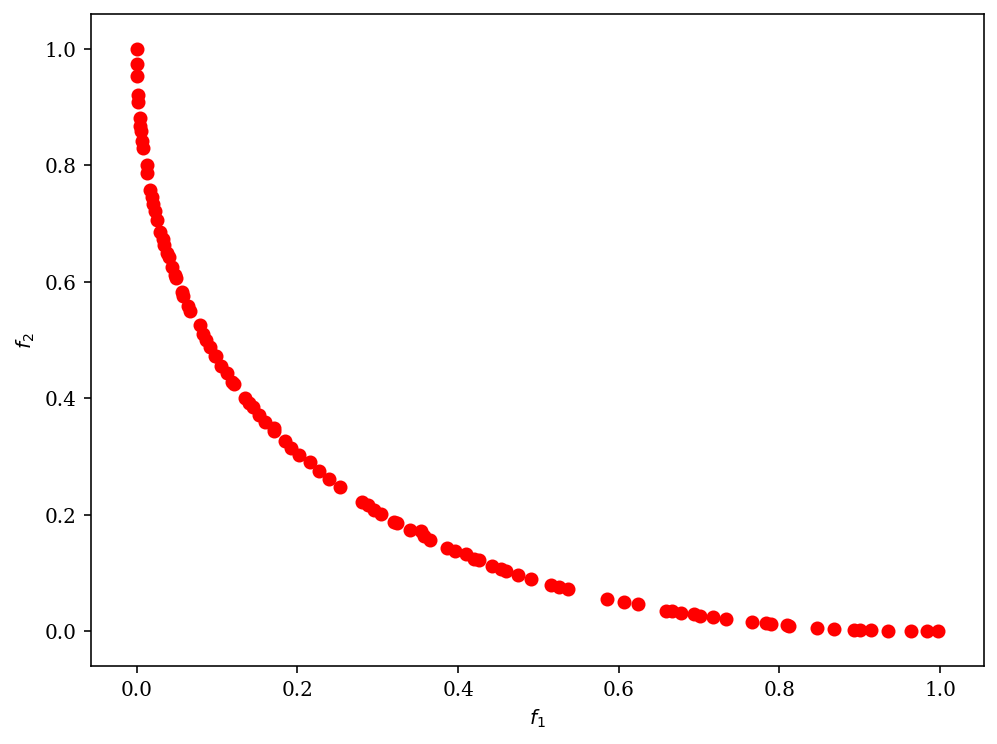

In [14]:
from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(pop_size=100, repair=MyRepair(), eliminate_duplicates=True)

from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

plot = Scatter()
plot.add(res.F, color="red")
plot.show()

In our case it is easy to verify if the constraint is violated or not:

In [15]:
print(res.X[:, 0] + res.X[:, 2])

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


If you would like to compare the solution without a repair you will see how searching only in the feasible space helps:

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  | delta_ideal  | delta_nadir  |   delta_f   
    1 |     100 |  0.000035699 |  7.218880160 |       1 |            - |            - |            -
    2 |     200 |  0.000035699 |  0.937483763 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    3 |     300 |  0.000035699 |  0.098161741 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    4 |     400 |  0.00000E+00 |  0.024978835 |       1 |  3.360562566 |  3.360562566 |  4.74270E+30
    5 |     500 |  0.00000E+00 |  0.007024606 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    6 |     600 |  0.00000E+00 |  0.001830226 |       1 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    7 |     700 |  0.00000E+00 |  0.000759620 |       2 |  1.000000000 |  1.000000000 |  0.707106781
    8 |     800 |  0.00000E+00 |  0.000303923 |       2 |  0.00000E+00 |  0.00000E+00 |  0.00000E+00
    9 |     900 |  0.00000E+00 |  0.000120410 |       2 |  0.00000E+00 |  0.00000E+00 |  0.

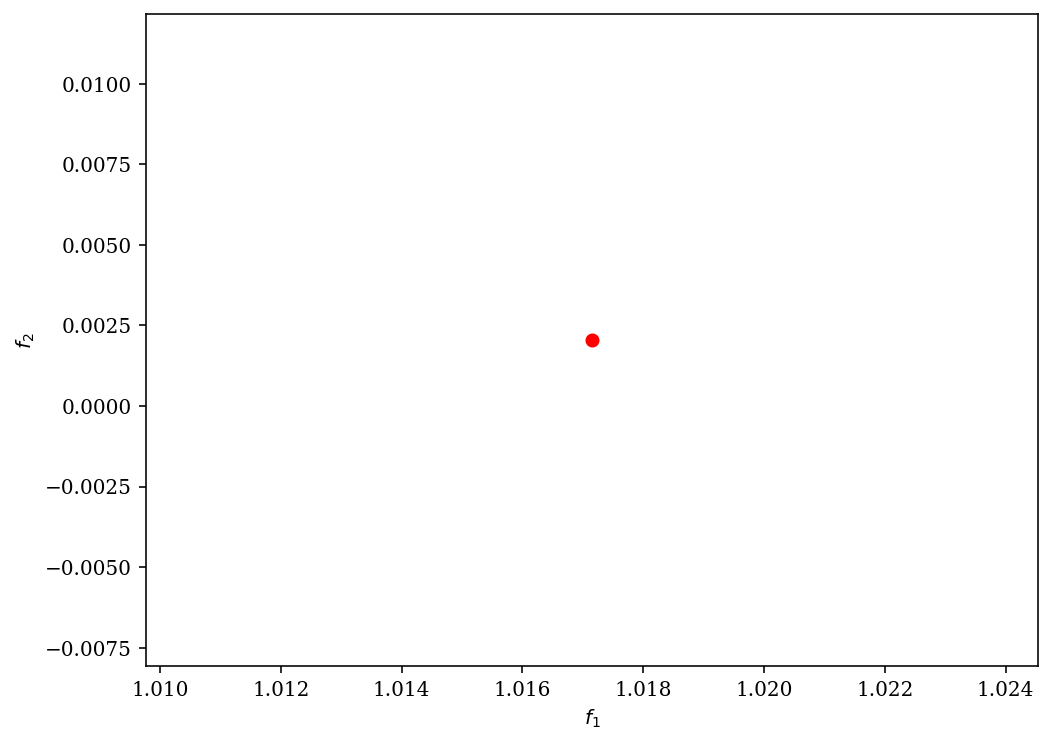

In [16]:
algorithm = NSGA2(pop_size=100, eliminate_duplicates=True)

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

plot = Scatter()
plot.add(res.F, color="red")
plot.show()



In [17]:
print(res.X[:, 0] + res.X[:, 2])

[1.99716258]


Here in fact the $\epsilon$ term is necessary to find any feasible solution at all.